In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

In [8]:
from models.BNNs.BNN_KDE_CLASSIFICATION import BNN_KDE

In [9]:
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))

        x = torch.tanh(self.fc2(x))

        x = self.fc3(x)

        return x
num_nodes = 2
net = Net(num_nodes=num_nodes)
    

print(net)


Net(
  (fc1): Linear(in_features=4, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=3, bias=True)
)


In [10]:
def compute_categorical_mixture(preds, y):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Categorical(logits=preds.permute(1, 0, 2))
    
    mixture_of_categorical = D.MixtureSameFamily(mix, comp)
    mean_preds = torch.argmax(mixture_of_categorical.component_distribution.probs.mean(1), dim=1).float()
    accuracy = torch.sum(mean_preds == y) / y.shape[0]
    
    ll = mixture_of_categorical.log_prob(y).sum()
    return accuracy, ll

def compute_ensemble_preds(preds, y):
    mean_probs = F.softmax(preds, dim=-1).mean(0)
    mean_preds = torch.argmax(mean_probs, dim=-1)
    ll = D.Categorical(probs=mean_probs).log_prob(y)

    accuracy = torch.sum(mean_preds == y) / y.shape[0]
    return accuracy, ll.sum()

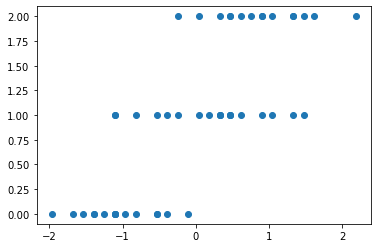

In [11]:
from sklearn.datasets import load_iris
import numpy as np
np.random.seed(0)
device = torch.device('cpu')
data = load_iris()
x_ = data['data']
y_ = data['target']
N_tr = 50
N_val = 150 - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [14]:
## Set hyperparameters for network
ELBO_BETA = .5
alpha = 1.
tau_list = []
tau = alpha * ELBO_BETA
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [15]:
hamiltorch.set_random_seed(1)
params_init = hamiltorch.util.flatten(net).to(device).clone()
print(params_init.shape)
step_size = 1.0
num_samples = 2500
burn = 500
L = 10
tau_out = 1.
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC_NUTS
params_hmc = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L, tau_out=tau_out, tau_list=tau_list,
                                    sampler=sampler, integrator=integrator, burn=burn, desired_accept_rate=0.8)

torch.Size([25])
Sampling (Sampler.HMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.09692821651697159--- |  495/2500 | 53.35       
0d:00:00:50 | 0d:00:00:00 | #################### | 2500/2500 | 49.05       
Acceptance Rate 0.68


In [16]:
hmc_weights = torch.empty([0])
for w in params_hmc:
    hmc_weights = torch.cat([hmc_weights, w[None]])

In [17]:
pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=hmc_weights, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list, y_val)

(tensor(0.9500), tensor(-15.0538))

In [18]:
pred_list_train, log_prob_list = hamiltorch.predict_model(net, x=x_train, y=y_train, samples=hmc_weights, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_train, y_train)

(tensor(0.9800), tensor(-6.7963))

# Draw subset of samples

In [19]:
g = torch.Generator()
g.manual_seed(1)
perm = torch.randperm(hmc_weights.size(0), generator=g)
num_s = 500
idx = perm[:num_s]
samples = hmc_weights[idx]
samples_rest = hmc_weights[perm[num_s:]]

In [20]:
pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=samples, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list, y_val)

(tensor(0.9500), tensor(-14.7205))

# Build a KDE

# KDE 100 Samples

In [21]:
# find optimal kde_var
from models.BNNs.BNN_KDE_CLASSIFICATION import BNN_KDE
from tqdm.notebook import trange

In [22]:
bnn_kde = BNN_KDE(alpha=alpha, emp_samples=samples, num_nodes=num_nodes, kl_beta=ELBO_BETA)

with torch.no_grad():
    rho_linspace = torch.linspace(-5, 5, 1000)
    rho_elbos = torch.zeros_like(rho_linspace)
    for i, rho in enumerate(rho_linspace):
        bnn_kde.log_kde_rho = nn.Parameter(rho)
        rho_elbos[i] = bnn_kde.elbo(x_train, y_train, 32)

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/pyro/distributions/torch_patch.py:81: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  return torch.stack([v.symeig(eigenvectors=False)[0][:1] > 0.0


In [23]:
initial_rho = rho_linspace[torch.argmax(rho_elbos)].item()

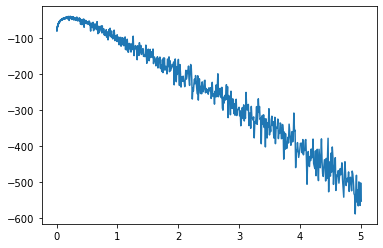

In [24]:
plt.plot(F.softplus(rho_linspace), rho_elbos.numpy())

In [25]:
bnn_kde.log_kde_rho = nn.Parameter(rho_linspace[torch.argmax(rho_elbos)])
KDE_target = bnn_kde.kde

In [26]:
from rec.utils import kl_estimate_with_mc
prior = D.MultivariateNormal(loc=torch.zeros_like(samples[0]), covariance_matrix = 1./alpha * torch.eye(samples.shape[-1]))
kl_q_p = kl_estimate_with_mc(KDE_target, prior)
print(f"{kl_q_p}")

55.034603118896484


In [27]:
num_compressed_samples = 1000
compressed_weights_kde_exact = KDE_target.sample((num_compressed_samples,))

pred_list_kde, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_kde_exact, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

In [28]:
compute_categorical_mixture(pred_list_kde, y_val)

(tensor(0.9500), tensor(-20.1442))

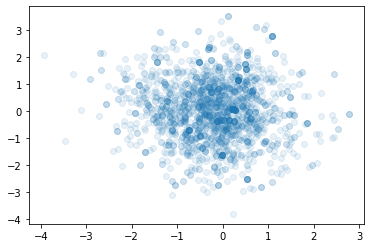

In [29]:
plt.scatter(hmc_weights[:, 0], hmc_weights[:, -1], alpha=0.1)

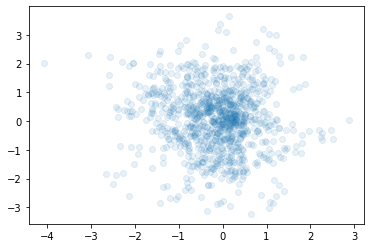

In [30]:
plt.scatter(compressed_weights_kde_exact[:, 0], compressed_weights_kde_exact[:, -1], alpha=0.1)

In [31]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

In [32]:
compute_expected_coding_efficiency(kl_q_p)

tensor(71.2468, grad_fn=<AddBackward0>)

# Lets optimise the variances

In [33]:
#lets compress some samples
#### sample weights with compression algorithm
from tqdm.notebook import trange
from rec.beamsearch.Coders.Encoder_Empirical import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
from models.BNNs.BNN_for_HMC_classification import BNN_for_HMC
import pyro.distributions as dist

In [34]:
dummy_model = BNN_for_HMC(alpha=alpha, num_nodes=num_nodes)

In [35]:
dummy_model.make_weights_from_sample(samples[0])

In [36]:
emp_dist = dist.Empirical(samples, log_weights=torch.ones(samples.shape[0]))

In [37]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
dummy_encoder = Encoder(dummy_model,
                     x_train,
                     y_train,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)

z_sample = emp_dist.mean
omega = 5
n_trajectories = 64
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, kl_q_p, n_trajectories, prior_var)
aux_vars = emp_opt.run_optimiser(epochs=2000)

The mean loss is 2.25457. The mean KL is: 4.96861: 100%|██████████| 2000/2000 [13:03<00:00,  2.55it/s]


# Let's use the EMP scheme

In [38]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 500
compressed_weights_emp_low_eps = []
pbar = trange(num_compressed_samples)
lps = []
for i in pbar:
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_train,
                     y_train,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    pbar.set_description(f"Log prob of sample is: {KDE_target.log_prob(w).detach().item()}")
    lps.append(KDE_target.log_prob(w).detach().item())
    compressed_weights_emp_low_eps.append(w[0])

  0%|          | 0/500 [00:00<?, ?it/s]

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [39]:
pred_list_emp_low_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_emp_low_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_emp_low_eps, y_val)

(tensor(0.9700), tensor(-34.0729))

In [40]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 500
compressed_weights_emp_med_eps = []
pbar = trange(num_compressed_samples)
for i in pbar:
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_train,
                     y_train,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    pbar.set_description(f"Log prob of sample is: {KDE_target.log_prob(w).detach().item()}")
    compressed_weights_emp_med_eps.append(w[0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
pred_list_emp_med_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_emp_med_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_emp_med_eps, y_val)

(tensor(0.9600), tensor(-30.2996))

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 500
compressed_weights_emp_high_eps = []
pbar = trange(num_compressed_samples)
for i in pbar:
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_train,
                     y_train,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    pbar.set_description(f"Log prob of sample is: {KDE_target.log_prob(w).detach().item()}")
    compressed_weights_emp_high_eps.append(w[0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
pred_list_emp_high_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_emp_high_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_emp_high_eps, y_val)

# Let's try the KDE coder

In [ ]:
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.KDEPosterior import KDEPosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
from rec.beamsearch.Coders.Encoder_KDE_BNN import EncoderKDE

In [ ]:
num_compressed_samples = 500
compressed_weights_kde_exact = KDE_target.sample((num_compressed_samples,))

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 500
compressed_weights_kde_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(model=dummy_model,
                         x_data=x_train,
                         y_data=y_train,
                         target=KDE_target,
                         initial_seed=initial_seed,
                         coding_sampler=coding_sampler,
                         selection_sampler=selection_sampler,
                         auxiliary_posterior=auxiliary_posterior,
                         omega=omega,
                         epsilon=epsilon,
                         beamwidth=beamwidth,
                         prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_low_eps.append(w[0])

In [ ]:
pred_list_kde_low_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_kde_low_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_kde_low_eps, y_val)

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 500
compressed_weights_kde_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(model=dummy_model,
                         x_data=x_train,
                         y_data=y_train,
                         target=KDE_target,
                         initial_seed=initial_seed,
                         coding_sampler=coding_sampler,
                         selection_sampler=selection_sampler,
                         auxiliary_posterior=auxiliary_posterior,
                         omega=omega,
                         epsilon=epsilon,
                         beamwidth=beamwidth,
                         prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_med_eps.append(w[0])

In [ ]:
pred_list_kde_med_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_kde_med_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_kde_med_eps, y_val)

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 500
compressed_weights_kde_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(model=dummy_model,
                         x_data=x_train,
                         y_data=y_train,
                         target=KDE_target,
                         initial_seed=initial_seed,
                         coding_sampler=coding_sampler,
                         selection_sampler=selection_sampler,
                         auxiliary_posterior=auxiliary_posterior,
                         omega=omega,
                         epsilon=epsilon,
                         beamwidth=beamwidth,
                         prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_high_eps.append(w[0])

In [ ]:
pred_list_kde_high_eps, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_kde_high_eps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

compute_categorical_mixture(pred_list_kde_high_eps, y_val)

In [ ]:
# dump the important stuff
import pickle as pkl
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/hmc_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(samples, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/HMC_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(KDE_target, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/HMC_KDE_target_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_emp_low_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/emp_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_emp_med_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/emp_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_emp_high_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/emp_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))
pkl.dump(compressed_weights_kde_exact, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/KDE/kde_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_kde_low_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/KDE/kde_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_kde_med_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/KDE/kde_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_kde_high_eps, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/KDE/kde_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))